# Student Name: Zhongyue Xing

# Preface

In this problem we consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" and "transplant". 

We assume that the Markov property holds. There are three additional states of the Markov Decision Process: "Pretransplant Death", "Posttransplant Life" and "Posttransplant Death" with no actions available. Assume that the length of episodes is T=50. "Pretransplant Death" and "Posttransplant Death" are absorbing states (time stops).

If patient selects "wait", the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Pretransplant Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Pretransplant Death  
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Pretransplant Death

If a patient selects "transplant" in Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there is the transition  
5) "Posttransplant Life"->"Posttransplant Death"  

Assume that   

P(Stage (k+1)|Stage k, "wait")=0.10 for k=1,2,...,17  
P(Stage (k-1)|Stage k, "wait")=0.02 for k=2,3,...,18  

P(Pretransplant Death|Stage k, "wait")=k*c for k=1,2,...,18 and some constant c.  

P(Stage k|Stage k, "wait")=0.9-kc for k=1   
P(Stage k|Stage k, "wait")=0.98-kc for k=18   
P(Stage k|Stage k, "wait")=0.88-kc for k=2,...,17   

Further, assume that   
P(Posttransplant Death|Posttransplant Life)= 4*c for the same constant c.


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


# Problem 1 (15 points)
Let policy $\pi$ be "wait" in all states. Assume that the state-value function $v_\pi(s)$ can be approximated by 
    
$\hat{v}_\pi(s,{\bf w})=w_1+w_2 \cdot k\cdot\mathbb{1}_{\{s=\text{"Stage k"}\}}+w_3 \cdot \mathbb{1}_{\{s=\text{"Posttransplant Life"}\}}+w_4 \cdot \mathbb{1}_{\{s=\text{"Posttransplant Death"}\}}+w_5 \cdot \mathbb{1}_{\{s=\text{"Pretransplant Death"}\}}$,     
    
where ${\bf w}=(w_1,w_2,w_3,w_4,w_5)^T$.


For c = 0.015 estimate the the state-value function $v_\pi(s)$ via the Gradient Monte Carlo Algorithm for Estimating $v_\pi\approx \hat{v}$ (algorithm on p. 202 of "Reinforcement Learning" by Sutton and Barto). Output final results for $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$. Plot $v_\pi(\{\text{Stage k}\})$ versus k. Discuss the results.  

## Environment

In [5]:
import numpy as np
import random

ESLD_STAGES = list(range(1, 19))

class ESLD:
    def __init__(self, stage, c = 0.015):
        """
        Generate an ESLD model for a patient in stage 1-18 of ESLD.

        If the patient is outside of stage 1-18, the patient is either dead
        or in "posttransplant life stage", which is represented as stage 0.

        Death is the terminal state of this model, it is stored as self.state = None.
        Initialising a dead patient is not a valid input.
        
        """
        assert stage in range(19), "stage must be 0-18 for live patient"
        self.state = stage
        self.c = c
        self.time = 0

    def admissible_actions(self):
        """ return all admissible actions for a state in the form of a list """
        if self.state in ESLD_STAGES:
            return [0, 1] # 0 correspond to "wait", 1 correspond to "transplant"
        elif self.state == 0:
            return [None]
        else:
            print(self.state)
            raise (ImplementationError, "state should not exist")
    
    def is_terminal(self):
        return self.state == "ND" or self.state == "TD"

    def get_reward(self, action):
        if action == None:
            # posttransplant life
            assert self.state == 0, "action only valid for post-transplant life"
            self.state = np.random.choice([0, "TD"], p = [1 - 4*self.c, 4*self.c])

            if self.state == 0:
                self.state = int(self.state)
                reward = 0.2
            else:
                # posttransplant death
                reward = 0

        elif action == 1:
            # transplant action
            self.state = 0
            reward = 0.2

        elif action == 0:
            # wait action
            new_states = [self.state-1, self.state, self.state+1, "ND"]
            p_new_states = [0.02, 0.88-self.c*self.state, 0.1, self.c*self.state]
    
            if self.state == 1:
                p_new_states[1] += 0.02
                del new_states[0]
                del p_new_states[0]
            elif self.state == 18:
                p_new_states[1] += 0.1
                del new_states[-2]
                del p_new_states[-2]

            self.state = np.random.choice(new_states, p = p_new_states)

            if self.state == "ND":
                # pretransplant (natural) death
                reward = 0
            else:
                self.state = int(self.state)
                reward = 1

        else:
            raise (TypeError, "action", action, "is invalid for", self.state)

        self.time += 1
        return reward

## Test Cases

In [7]:
# define test policy
policy = {state:[1, 0] for state in ESLD_STAGES} # always choose action 0 which is "wait"
policy[0] = [1]  # policy for posttransplant life is 100% pass

# value function
def v(state, w):
    s = np.array([1, state*(state in ESLD_STAGES), state == 0, state == "PD", state == "ND"])
    return np.dot(s, w)
# partial derivitive of value function (by w)
def dv(state, w):
    s = np.array([1, state*(state in ESLD_STAGES), state == 0, state == "PD", state == "ND"])
    return s

## Algorithm and Output

Weight: [14.40460117 -1.07269066  0.          0.          0.        ]


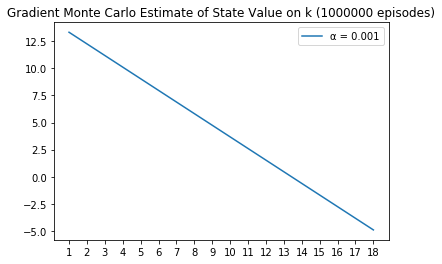

In [7]:
def generate_ESLD_episode(policy, stage = None):
    if not stage:
        stage = random.choice(ESLD_STAGES)
    else:
        assert stage in ESLD_STAGES
    env = ESLD(stage)
    record = {"s":[], "a":[], "r":[]}

    while True:
        record["s"].append(env.state)

        selected_action = np.random.choice(env.admissible_actions(), p = policy[env.state])
        record["a"].append(selected_action)

        reward = env.get_reward(selected_action)
        record["r"].append(reward)

        if env.is_terminal() or env.time >= 100: # patient lives no longer than 100 years post diagnosis
            return record

def gradient_MC_estimate(v, dv, policy, alpha = 0.001, gamma = 0.97, n_eps = 1000000):
    w = np.zeros(5)  # initial value function weight

    for eps in range(n_eps):
        episode = generate_ESLD_episode(policy)
        G = 0
        t_max = len(episode["s"])
        for t in range(-1, -t_max-1, -1):
            G = gamma*G + episode["r"][t]  # reward time offset is embeded
            s = episode["s"][t]

            w += alpha*(G - v(s, w))*dv(s, w)

    return w


n_eps = 1000000
alpha = 0.001
w = gradient_MC_estimate(v = lambda s, w: v(s, w), dv = lambda s, w: dv(s, w), policy = policy, alpha = alpha, n_eps = n_eps)
print("Weight:", w)

from matplotlib import pyplot as plt
plt.plot(ESLD_STAGES, [v(s, w) for s in ESLD_STAGES], label='α = {}'.format(alpha))
plt.title('Gradient Monte Carlo Estimate of State Value on k ({} episodes)'.format(n_eps))
plt.legend()
plt.xticks(np.arange(1, 19, 1.0))
plt.show()

## Discussion
The result shows a decreasing trend as expected since higher stage number (k) have higher chance of death which leads to lower state values. The result shows that for stage 13 and beyond the expected state value is negative, which is impossible for our model that does not contain negative reward. Such estimate is likely a result of the state estimate function s. s is chosen to be a linear function of k while the relationship between k and state value is non-linear. Additionally, the stochastic nature of this model may led to misfit of the model. 

# Problem 2 (10 points)
Modify the algorithm you developed in Problem 1 and estimate the state-value function $v_\pi(s)$ via the Semi-gradient TD(0) for estimating $v_\pi\approx \hat{v}$ (algorithm on p. 203 of "Reinforcement Learning" by Sutton and Barto) for c=0.015. Output final results for $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$. Plot $v_\pi(\{\text{Stage k}\})$ versus k. Discuss the results.

Weight: [13.43810252 -0.97205488  0.          0.          0.        ]


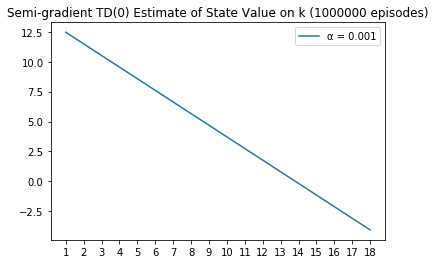

In [20]:
def semigradient_TD0_estimate(v, dv, policy, alpha = 0.001, gamma = 0.97, n_eps = 1000000):
    w = np.zeros(5)  # initial value function weight

    for eps in range(n_eps):
        s = random.choice(ESLD_STAGES)
        env = ESLD(s)

        while True:
            a = np.random.choice(env.admissible_actions(), p = policy[env.state])
            r = env.get_reward(a)
            s_next = env.state

            if env.is_terminal() or env.time >= 100:
                # s is the terminal state
                w += alpha*(r - v(s, w))*dv(s, w)
                break

            else:
                w += alpha*(r + gamma*v(s_next, w) - v(s, w))*dv(s, w)

            s = env.state
    return w

n_eps = 1000000
alpha = 0.001
w = semigradient_TD0_estimate(v = lambda s, w: v(s, w), dv = lambda s, w: dv(s, w), policy = policy, alpha = alpha, n_eps = n_eps)
print("Weight:", w)


from matplotlib import pyplot as plt
plt.plot(ESLD_STAGES, [v(s, w) for s in ESLD_STAGES], label='α = {}'.format(alpha))
plt.title('Semi-gradient TD(0) Estimate of State Value on k ({} episodes)'.format(n_eps))
plt.legend()
plt.xticks(np.arange(1, 19, 1.0))
plt.show()

## Discussion
The semi-gradient TD(0) estimate converged to similar state value estimates when compared to the gradient Monte Carlo estimate. This is expected since the number of episode (amount of data generated) is sufficiently large for convergence. The speed of convergence for semi-gradient method may be slower due to its use of estimated future values instead of true future value (G).

In [11]:
exit